<a href="https://colab.research.google.com/github/mounsifelatouch/cdd/blob/master/notebooks/4_cdd_ml_part_4_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Project - Computational Drug Discovery [Part 4] Classification Models Building**

**MOUNSIF EL ATOUCH**

In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 4**, we will be building classification models

---

## **1. Installing librairies**

## **2. Importing libraries**

In [1]:
import os
import pandas as pd

from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

seed = 42

from sklearn.model_selection import *
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import *

from scipy.stats import randint, uniform

from scipy import interp
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [3]:
def print_auc(clf, X_train, y_train, X_test, y_test, model_name) :
    
    clf = clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, thr = roc_curve(y_test,  y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=model_name+" auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.title("ROC curve")

    plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds_log = precision_recall_curve(y_test, y_pred_proba)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    
    plt.plot(recall, precision, label=model_name+" auc_prc="+str(auc_precision_recall))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc=4)
    plt.title("Precision-Recall Curve")

    plt.show()
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    print_score(clf, X_train, y_train, X_test, y_test, train=False)
    precision_sc=precision_score(y_test, clf.predict(X_test), average=None)
    recall_sc = recall_score(y_test, clf.predict(X_test), average=None)
    test_score = accuracy_score(y_test, clf.predict(X_test)) * 100
    train_score = accuracy_score(y_train, clf.predict(X_train)) * 100
    f1 = f1_score(y_test, clf.predict(X_test))
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    metriques = {"fpr" : fpr, "recall_sc" : recall_sc, "precision_sc" : precision_sc, "tpr" : tpr,
                 "test_score" : test_score, "train_score" : train_score, "f1" : f1,
                 "auc_pr" : auc_precision_recall, "auc": roc_auc}
    return metriques

In [4]:
def metrics(X_train, X_test, y_train, y_test, model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Training set accuracy: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set accuracy: {:.2f}".format(model.score(X_test, y_test)))
    print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y_test, y_proba)))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives: {:.0f}".format(tn))
    print("False Positives: {:.0f}".format(fp))
    print("False Negatives: {:.0f}".format(fn))
    print("TruePositives: {:.0f}".format(tp))
    print("-------------------------------------")
    return

## **4. Load the data set**

In [5]:
! wget https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv

--2023-06-04 23:59:52--  https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1090920 (1.0M) [text/plain]
Saving to: ‘bioactivity_data_PubchemFingerprinter.csv’

bioactivity_data_Pu 100%[===================>]   1.04M  --.-KB/s    in 0.02s   

2023-06-04 23:59:52 (50.9 MB/s) - ‘bioactivity_data_PubchemFingerprinter.csv’ saved [1090920/1090920]



In [6]:
df = pd.read_csv('bioactivity_data_PubchemFingerprinter.csv')

## **5. Input features**

### **5.1. Input features**

In [8]:
X = df.drop('activity', axis=1)

### **5.2. Output features**

In [9]:
y = df['activity']

In [10]:
# count the number of instances in each class
counts = y.value_counts()

# calculate the ratio of the negative class to the positive class
imbalance_ratio = counts[0] / counts[1]

### **5.3. Let's examine the data dimension**

In [11]:
X.shape, y.shape

((612, 881), (612,))

### **5.4. Remove low variance features**

In [12]:
# Create a VarianceThreshold object
selector = VarianceThreshold(threshold=.01)

# Fit the selector to the data and transform the data
selector.fit_transform(X)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

X_reduced = X[selected_features]

In [13]:
X.shape, X_reduced.shape

((612, 881), (612, 428))

## **6. Data split (80/20 ratio)**

In [14]:
n = np.arange(len(X_reduced))
idx_train, idx_test = train_test_split(n, stratify=y, test_size=.2, random_state=seed)

In [15]:
X1_train, y1_train = X_reduced.loc[idx_train], y.loc[idx_train]
X1_test, y1_test = X_reduced.loc[idx_test], y.loc[idx_test]

In [16]:
X1_train.shape, y1_train.shape

((489, 428), (489,))

In [17]:
X1_test.shape, y1_test.shape

((123, 428), (123,))



---



In [18]:
X = X1_train.reset_index(drop=True)
y = y1_train.reset_index(drop=True)
X1_test = X1_test.reset_index(drop=True)
y1_test = y1_test.reset_index(drop=True)

In [19]:
n_samples, n_classes = X.shape[0], 2
class_weights = dict(zip(np.unique(y), n_samples / (n_classes * np.bincount(y))))

## **7. Modeling**

## **Logistic Regression**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8548712690817954
Best Hyperparameters: {'C': 0.5403916872521951, 'class_weight': 'balanced', 'max_iter': 297, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.9183673469387755, Precision: 0.8695652173913043, Recall: 0.8, f1_score: 0.8333333333333333
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8550303892409156
Best Hyperparameters: {'C': 48.21086911696349, 'class_weight': None, 'max_iter': 187, 'penalty': 'none', 'solver': 'sag'}
Accuracy: 0.9183673469387755, Precision: 0.8, Recall: 0.9230769230769231, f1_score: 0.8571428571428571
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8646140536920243
Best Hyperparameters: {'C': 76.04943648035129, 'cl

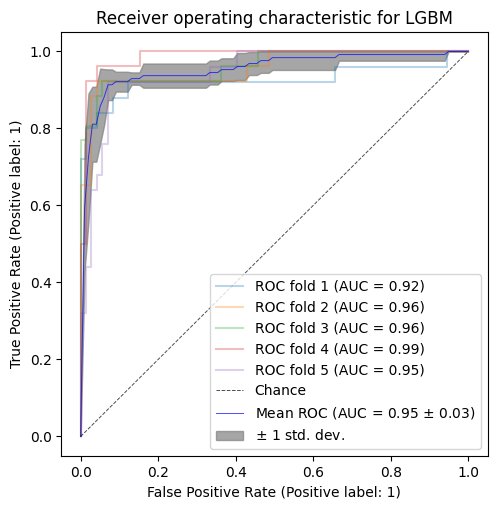

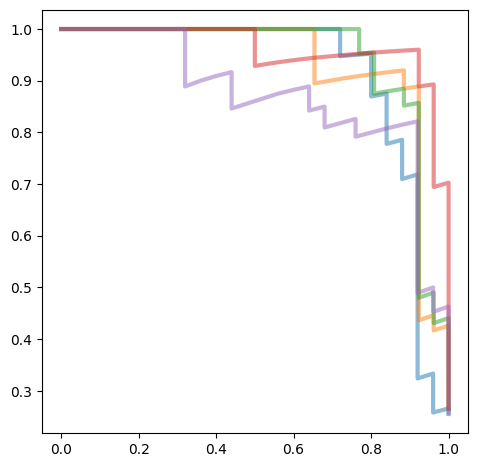

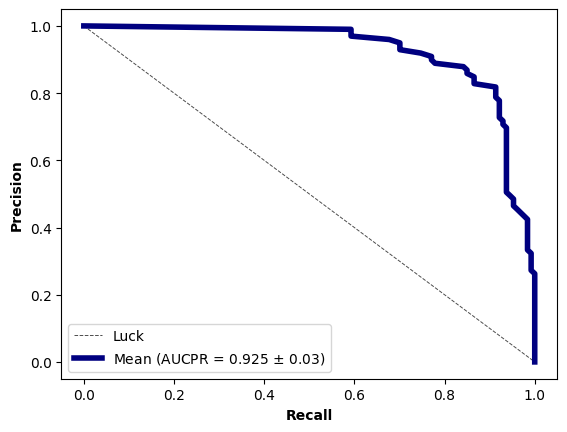

List of possible accuracy: 
 [0.8333333333333333, 0.8571428571428571, 0.875, 0.8771929824561403, 0.7916666666666667]
Maximum Accuracy That can be obtained from this model is: 
 87.71929824561403 %
Minimum Accuracy: 
 79.16666666666667 %
Overall Accuracy: 
 84.68671679197995 %
Standard Deviation is: 
 0.035520983496959584
List of possible accuracy for trainning: [98.20971867007673, 99.23273657289002, 98.9769820971867, 98.20971867007673, 99.23469387755102]
List of possible accuracy for testing: [91.83673469387756, 91.83673469387756, 93.87755102040816, 92.85714285714286, 89.69072164948454]
Mean Accuracy: 0.9201977698295813, Mean Precision: 0.8513298482723448, Mean Recall: 0.8504615384615384, Mean f1_score: 0.7916666666666667


In [20]:
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

space = dict()
space['class_weight'] = [class_weights, None, 'balanced']
space['solver'] = ['lbfgs', 'liblinear', 'newton-cg', 'sag']
space['penalty'] = ['l1', 'l2', 'none']
space['C'] = uniform(0.1, 100)
space['max_iter'] = randint(100, 500)


train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=space, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [24]:
model1 = LogisticRegression(C=2.1111442807251413, class_weight={0: 0.6772853185595568, 1: 1.91015625},
                            max_iter=222, penalty='l1', solver='liblinear').fit(X1_train, y1_train)

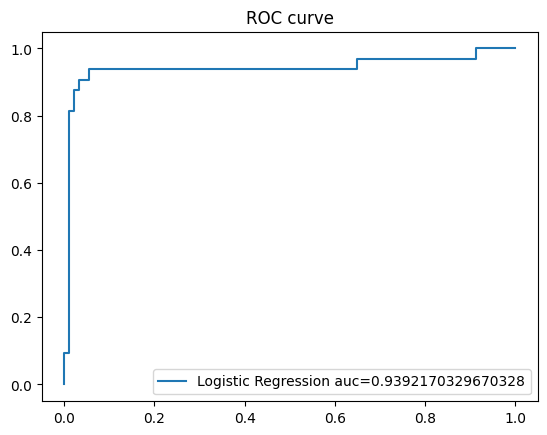

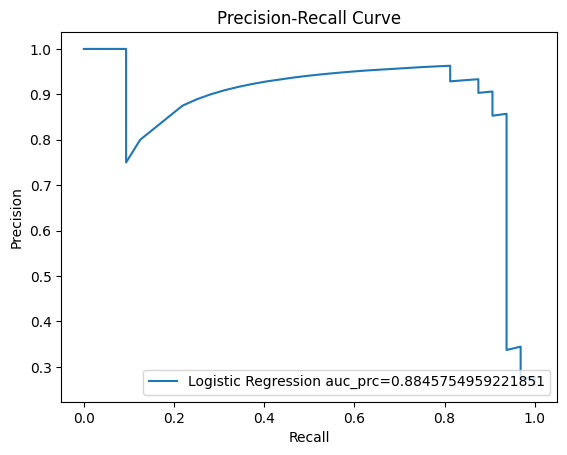

Train Result:
Accuracy Score: 97.75%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.997159    0.927007  0.977505    0.962083      0.978796
recall       0.972299    0.992188  0.977505    0.982243      0.977505
f1-score     0.984572    0.958491  0.977505    0.971531      0.977745
support    361.000000  128.000000  0.977505  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[351  10]
 [  1 127]]

Test Result:
Accuracy Score: 92.68%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.976744   0.810811  0.926829    0.893777      0.933575
recall      0.923077   0.937500  0.926829    0.930288      0.926829
f1-score    0.949153   0.869565  0.926829    0.909359      0.928447
support    91.000000  32.000000  0.926829  123.000000    123.000000
___

,Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
0,Logistic Regression,0.869565,0.939217,0.884575,0.923077,0.9375,0.976744,0.810811


In [25]:
clf = print_auc(model1, X1_train, y1_train, X1_test, y1_test, 'Logistic Regression')
results_df = pd.DataFrame(data=[['Logistic Regression', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])

results_df.style.hide_index()

## **SVC**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8995184055876058
Best Hyperparameters: {'C': 84.71206046236264, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'auto'}
Accuracy: 0.9285714285714286, Precision: 0.875, Recall: 0.84, f1_score: 0.8571428571428572
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8705461442303548
Best Hyperparameters: {'C': 41.5448042408726, 'class_weight': None, 'degree': 4, 'gamma': 'auto'}
Accuracy: 0.9387755102040817, Precision: 0.8571428571428571, Recall: 0.9230769230769231, f1_score: 0.888888888888889
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8933562643318741
Best Hyperparameters: {'C': 12.712219946447457, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'a

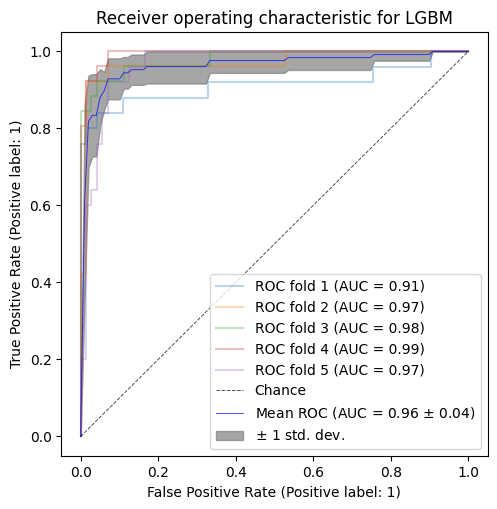

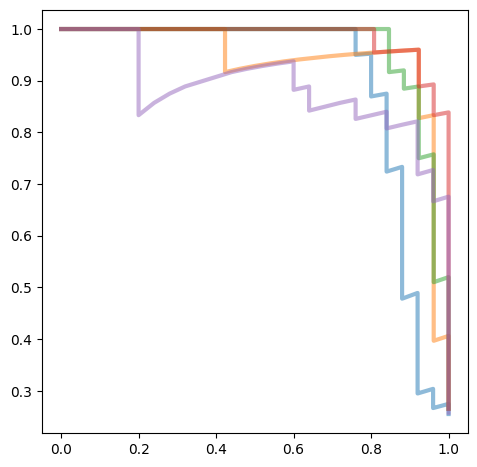

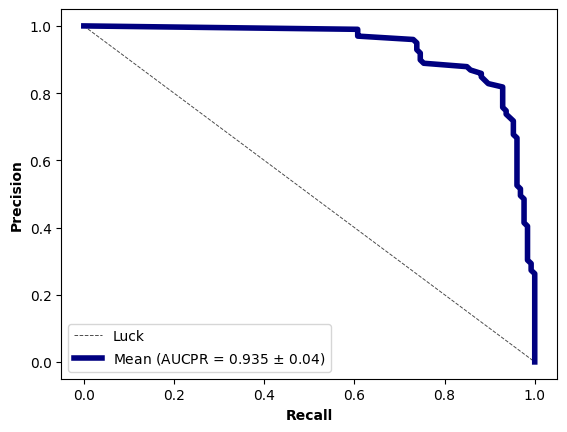

List of possible accuracy: 
 [0.8571428571428572, 0.888888888888889, 0.9166666666666666, 0.9056603773584906, 0.8235294117647058]
Maximum Accuracy That can be obtained from this model is: 
 91.66666666666666 %
Minimum Accuracy: 
 82.35294117647058 %
Overall Accuracy: 
 87.83776403643219 %
Standard Deviation is: 
 0.03801357592228788
List of possible accuracy for trainning: [98.9769820971867, 98.72122762148338, 96.9309462915601, 95.65217391304348, 99.48979591836735]
List of possible accuracy for testing: [92.85714285714286, 93.87755102040816, 95.91836734693877, 94.89795918367348, 90.72164948453609]
Mean Accuracy: 0.9365453397853987, Mean Precision: 0.8857448107448107, Mean Recall: 0.8744615384615384, Mean f1_score: 0.8235294117647058


In [26]:
from sklearn.svm import SVC  

clf1 = SVC(probability=True)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'C': uniform(0.1, 100),
              'degree': randint(2, 5),
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced', class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [27]:
model2 = SVC(C=12.712219946447457, kernel='rbf', gamma='auto', class_weight='balanced', probability=True, degree=2).fit(X1_train, y1_train)

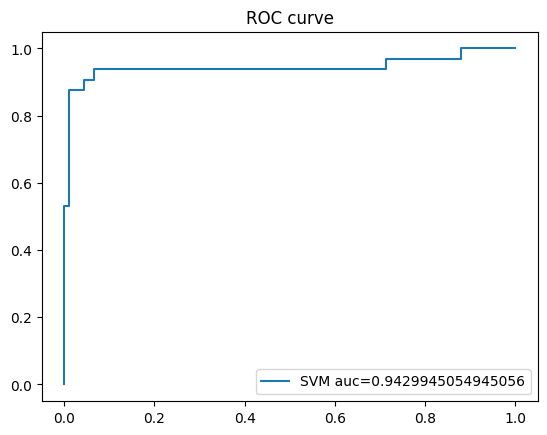

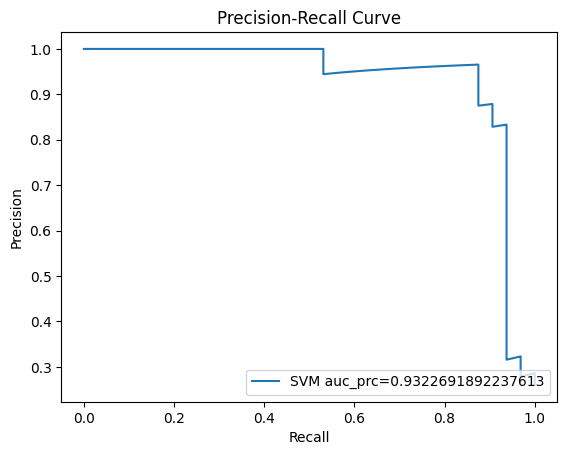

Train Result:
Accuracy Score: 96.32%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.983099    0.910448   0.96319    0.946773      0.964082
recall       0.966759    0.953125   0.96319    0.959942      0.963190
f1-score     0.974860    0.931298   0.96319    0.953079      0.963457
support    361.000000  128.000000   0.96319  489.000000    489.000000
_______________________________________________
Confusion Matrix: 
 [[349  12]
 [  6 122]]

Test Result:
Accuracy Score: 93.50%
_______________________________________________
CLASSIFICATION REPORT:
                   0          1  accuracy   macro avg  weighted avg
precision   0.966292   0.852941  0.934959    0.909617      0.936802
recall      0.945055   0.906250  0.934959    0.925652      0.934959
f1-score    0.955556   0.878788  0.934959    0.917172      0.935583
support    91.000000  32.000000  0.934959  123.000000    123.000000
___

,Model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
0,Logistic Regression,0.869565,0.939217,0.884575,0.923077,0.93750,0.976744,0.810811
0,SVM,0.878788,0.942995,0.932269,0.945055,0.90625,0.966292,0.852941


In [28]:
clf = print_auc(model2, X1_train, y1_train, X1_test, y1_test, 'SVM')
results_df2 = pd.DataFrame(data=[['SVM', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]],  
                          columns=['Model', 'f1_score', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df2)

results_df.style.hide_index()

## **Gradient Boosting Classifier**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'learning_rate': uniform(1e-5, 1),
              'subsample': uniform(0.8, 1),
              'n_estimators' : randint(100, 1000),
              'max_features' : ['log2', 'sqrt', 'auto'],
              'max_depth': randint(3, 10)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8865747702589808
Best Hyperparameters: {'learning_rate': 0.7028678761257883, 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 777, 'subsample': 0.8779978991995281}
Accuracy: 0.9387755102040817, Precision: 0.9130434782608695, Recall: 0.84, f1_score: 0.8749999999999999
Fitting 5 folds for each of 100 candidates, totalling 500 fits
--------------------------------------------------------------------
Best Score: 0.8586378302681255
Best Hyperparameters: {'learning_rate': 0.6531753912244718, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 883, 'subsample': 0.849579765424102}
Accuracy: 0.9285714285714286, Precision: 0.8064516129032258, Recall: 0.9615384615384616, f1_score: 0.8771929824561403
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
model3 = GradientBoostingClassifier(learning_rate=0.02 , subsample=0.2, n_estimators=100, max_features='log2', max_depth=8).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model3, X1_train, y1_train, X1_test, y1_test, 'Gradient Boosting')
results_df3 = pd.DataFrame(data=[['Gradient Boosting', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc','auc_pr','recall_classe(0)','recall_classe(1)','precision_classe(0)','precision_classe(1)'])
results_df = results_df.append(results_df3)

results_df.style.hide_index()

## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(random_state=seed)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(50, 1000),
              'max_depth': randint(3, 10),
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 5),
              'max_features': ['sqrt', 'log2', None],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:', max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:', min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:', mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model4 = RandomForestClassifier(n_estimators=100, max_features='log2', max_depth=30, criterion='entropy').fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model4, X1_train, y1_train, X1_test, y1_test, 'Random Forest')
results_df3 = pd.DataFrame(data=[['Random Forest', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df3, ignore_index=True)

results_df

## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf1 = KNeighborsClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_neighbors': randint(3, 7),
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['brute'],
              'leaf_size': randint(10, 50)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)

for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model5 = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='euclidean').fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model5, X1_train, y1_train, X1_test, y1_test, 'KNeibors Classifier')
results_df4 = pd.DataFrame(data=[['KNeibors Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df4, ignore_index=True)

results_df

## **ExtraTrees**

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

clf1 = ExtraTreesClassifier(random_state=0)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(100, 1000),
              'max_depth': randint(10, 100),
              'max_features': ['sqrt', 'log2'],
              'min_samples_split' : randint(2, 10), 
              'min_samples_leaf' : randint(1, 10),
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model6 = ExtraTreesClassifier(random_state=1, n_estimators=320, max_depth=25).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model6, X1_train, y1_train, X1_test, y1_test, 'ExtraTrees Classifier')
results_df5 = pd.DataFrame(data=[['ExtraTrees Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df5, ignore_index=True)

results_df

## **AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = AdaBoostClassifier(random_state=0)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'n_estimators': randint(50, 200),
              'learning_rate': uniform(1e-5, 1),
              'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3), None]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is \n max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model7 = AdaBoostClassifier(algorithm='SAMME.R', n_estimators=1000, learning_rate=0.1).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model7, X1_train, y1_train, X1_test, y1_test, 'AdaBoost Classifier')
results_df6 = pd.DataFrame(data=[['AdaBoost Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df6, ignore_index=True)

results_df

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf1 = DecisionTreeClassifier(random_state=0)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'min_samples_split': randint(2, 20),
              'max_depth': randint(3, 10),
              'min_samples_leaf': randint(2, 10),
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features': ['auto', 'sqrt', 'log2']}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model8 = DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=3, max_depth=5, criterion='entropy').fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model8, X1_train, y1_train, X1_test, y1_test, 'DecisionTree Classifier')
results_df7 = pd.DataFrame(data=[['DecisionTree Classifier', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df7, ignore_index=True)

results_df

## **GaussianNB**


In [ ]:
from sklearn.naive_bayes import GaussianNB

clf1 = GaussianNB()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'var_smoothing': uniform(1e-9, 1e-6)}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model9 = GaussianNB(var_smoothing=0.1).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model9, X1_train, y1_train, X1_test, y1_test, 'GaussianNB')
results_df8 = pd.DataFrame(data=[['GaussianNB', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df8, ignore_index=True)

results_df

## **LGBM**

In [ ]:
import lightgbm as lgb

clf1 = lgb.LGBMClassifier()

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'num_leaves': randint(10, 30),
              'max_depth': randint(3, 10),
              'learning_rate': uniform(1e-5, 1),
              'n_estimators': randint(50, 200),
              'min_child_samples': randint(10, 30),
              'subsample': uniform(0.8, 1),
              'colsample_bytree': uniform(0.8, 1),
              'class_weight' : ['balanced', None, class_weights]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model10 = lgb.LGBMClassifier(num_leaves=31, reg_alpha=0.1, lambda_l1=0, lambda_l2=0, min_data_in_leaf=100 ).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model10, X1_train, y1_train, X1_test, y1_test, 'LGBN')
results_df9 = pd.DataFrame(data=[['LGBM', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df9, ignore_index=True)

results_df

## **XGB**

In [ ]:
import xgboost as xgb

clf1 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=imbalance_ratio)

cross_val = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots(figsize=(5.5, 5.5))

tprs, aucs, y_real, y_prob, prs = [], [], [], [], []

mean_recall = np.linspace(0, 1, 100)
    
plt.figure(figsize=(5.5 , 5.5))

accs, precs, recs, f1_scr = [], [], [], []

mean_recall = np.linspace(0, 1, 100)
mean_fpr = np.linspace(0, 1, 100)

i=0

param_grid = {'learning_rate' : uniform(1e-5, 1),
              'max_depth' : randint(3, 25),
              'gamma' : uniform(0.1, 1),
              'subsample': uniform(0.5, 1),
              'colsample_bytree': uniform(0.5, 1),
              'scale_pos_weight': [1, imbalance_ratio]}

train_accuracy_list = []
test_accuracy_list = []
lst_accu_stratified = []

index_iterator = cross_val.split(X, y)

clf_random = clf_random = RandomizedSearchCV(estimator=clf1, param_distributions=param_grid, n_iter=100, scoring='f1', cv=cross_val, verbose=2, n_jobs=-1)
for train_index, test_index in index_iterator:
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
  
    clf_random.fit(X_train, y_train)
    pred_proba = clf_random.predict_proba(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba[:, 1])
    prs.append(interp(mean_recall, precision, recall))
    pr_auc = auc(recall, precision)
    aucs.append(pr_auc)
    plt.plot(recall, precision, lw=3, alpha=0.5, label='Fold %d (AUCPR = %0.2f)' % (i+1, pr_auc))

    viz = RocCurveDisplay.from_estimator(clf_random, X_test, y_test, name='ROC fold {}'.format(i+1), ax=ax, alpha=.3)

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    lst_accu_stratified.append(clf_random.score(X_test, y_test))
    y_train_pred = clf_random.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
    train_accuracy_list.append(train_accuracy)
    y_test_pred = clf_random.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel())*100
    test_accuracy_list.append(test_accuracy)
    print('--------------------------------------------------------------------')
    print('Best Score: %s'.format(i) % clf_random.best_score_)
    print('Best Hyperparameters: %s'.format(i) % clf_random.best_params_)
    acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred)
    rec = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test,y_test_pred)
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1_scr.append(f1)
    print(f'Accuracy: {acc}, Precision: {prec}, Recall: {rec}, f1_score: {f1}')
    i=i+1


ax.plot([0, 1], [0, 1], linestyle='--', lw=.7, color='black', label='Chance', alpha=.7)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=.7, alpha=.7)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.7, label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic for LGBM")
ax.legend(loc="lower right")
plt.show()

plt.plot([0, 1], [1, 0], linestyle='--', lw=.7, color='k', label='Luck', alpha=.7)
mean_precision = np.mean(prs, axis=0)
mean_auc = auc(mean_recall, mean_precision)
std_auc = np.std(aucs)
plt.plot(mean_precision, mean_recall, color='navy',label=r'Mean (AUCPR = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=4)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall' ,  fontweight = "bold" , fontsize=10)
plt.ylabel('Precision',fontweight = "bold" , fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend( prop={'size':10} , loc = 0)
plt.show()

from statistics import mean
from statistics import stdev

print('List of possible accuracy: \n', lst_accu_stratified)
print('Maximum Accuracy That can be obtained from this model is: \n', max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy: \n', min(lst_accu_stratified)*100, '%')
print('Overall Accuracy: \n', mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is: \n', stdev(lst_accu_stratified))

print('List of possible accuracy for trainning:', train_accuracy_list)
print('List of possible accuracy for testing:', test_accuracy_list)

print(f'Mean Accuracy: {np.mean(accs)}, Mean Precision: {np.mean(precs)}, Mean Recall: {np.mean(recs)}, Mean f1_score: {np.mean(f1)}')

In [ ]:
model11 = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=imbalance_ratio, learning_rate=, max_depth=, subsample=, colsample_bytree=, reg_alpha=, reg_lambda=).fit(X1_train, y1_train)

In [ ]:
clf = print_auc(model11, X1_train, y1_train, X1_test, y1_test, 'XGB Classifer')
results_df10 = pd.DataFrame(data=[['XGB Classifer', clf['f1'], clf['auc'], clf['auc_pr'], clf['recall_sc'][0], clf['recall_sc'][1], clf['precision_sc'][0], clf['precision_sc'][1]]], 
                          columns=['Model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
results_df = results_df.append(results_df10, ignore_index=True)

results_df

In [ ]:
def plot_feature_importances(clf, X_train, y_train=None, top_n=10, figsize=(5.5, 5.5), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (LightGBMError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

In [ ]:
my_clf = lgb.LGBMClassifier(num_leaves=31, reg_alpha=0.1, lambda_l1=0, lambda_l2=0, min_data_in_leaf=100)

In [ ]:
plot_feature_importances(my_clf, X1_train, y1_train, top_n=X1_train.shape[1], title=clf.__class__.__name__)

In [ ]:
clf1 = print_auc(model1, X1_train, y1_train, X1_test, y1_test, "Logistic Regression")
clf2 = print_auc(model2, X1_train, y1_train, X1_test, y1_test, "SVM")
clf3 = print_auc(model3, X1_train, y1_train, X1_test, y1_test, "Gradient Boosting")
clf4 = print_auc(model4, X1_train, y1_train, X1_test, y1_test, "Random Forest")
clf5 = print_auc(model5, X1_train, y1_train, X1_test, y1_test, "KNeighbors Classifier")
clf6 = print_auc(model6, X1_train, y1_train, X1_test, y1_test, "ExtraTrees Classifier")
clf7 = print_auc(model7, X1_train, y1_train, X1_test, y1_test, "Adaboost Classifier")
clf8 = print_auc(model8, X1_train, y1_train, X1_test, y1_test, "DecisionTree  Classifier ")
clf9 = print_auc(model9, X1_train, y1_train, X1_test, y1_test, "GaussianNB")
clf10 = print_auc(model10, X1_train, y1_train, X1_test, y1_test, "LGBM")
clf11 = print_auc(model10, X1_train, y1_train, X1_test, y1_test, "XGB")

In [ ]:
plt.rcParams["figure.figsize"] = [16, 8]
plt.plot(clf10["fpr"], clf10["tpr"], label="LGBM, auc="+str(clf10["auc"]))
plt.plot(clf1["fpr"], clf1["tpr"], label="LR, auc="+str(clf1["auc"]))
plt.plot(clf2["fpr"], clf2["tpr"], label="SVM, auc="+str(clf2["auc"]))
plt.plot(clf3["fpr"], clf3["tpr"], label="GB, auc="+str(clf3["auc"]))
plt.plot(clf6["fpr"], clf6["tpr"], label="ExtraTree, auc="+str(clf6["auc"]))
plt.plot(clf5["fpr"], clf5["tpr"], label="KNN, auc="+str(clf5["auc"]))
plt.plot(clf8["fpr"], clf8["tpr"], label="DT, auc="+str(clf8["auc"]))
plt.plot(clf9["fpr"], clf9["tpr"], label="GaussianNB, auc="+str(clf9["auc"]))
plt.plot(clf4["fpr"], clf4["tpr"], label="RF, auc="+str(clf4["auc"]))
plt.plot(clf7["fpr"], clf7["tpr"], label="AdaBoost, auc="+str(clf7["auc"]))
plt.plot(clf11["fpr"], clf11["tpr"], label="XGB, auc="+str(clf11["auc"]))

plt.xlabel("tpr")
plt.ylabel("fpr")
plt.legend(loc=4)
plt.savefig('figure.png', dpi=300)
plt.show()
